In [468]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import itertools
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [469]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [470]:
crop = 'Maize'
wxData = 'era5'

yieldDataOld = False

tempYearRange = [1981, 2018]
if yieldDataOld:
    yieldYearRange = [1981, 2008]
else:
    yieldYearRange = [1981, 2013]

yearRange = np.intersect1d(np.arange(tempYearRange[0], tempYearRange[1]+1), np.arange(yieldYearRange[0], yieldYearRange[1]+1))

In [471]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)


In [472]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [473]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    kdd = pickle.load(f)
    if wxData == 'cpc': kdd = kdd[:,:,1:]

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    gdd = pickle.load(f)
    if wxData == 'cpc': gdd = gdd[:,:,1:]
    
tx95 = np.full(gdd.shape, np.nan)
txMean = np.full(gdd.shape, np.nan)
for y, year in enumerate(range(tempYearRange[0], tempYearRange[1]+1)):
    with gzip.open('%s/tx95-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curTx95 = pickle.load(f)
        tx95[:, :, y] = curTx95

    with gzip.open('%s/txMean-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curTxMean = pickle.load(f)
        txMean[:, :, y] = curTxMean

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLon = pickle.load(f)


In [474]:
maizeYield = []
for year in range(yieldYearRange[0],yieldYearRange[1]+1):
    
    if yieldDataOld:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield/Maize_areaweightedyield_%d.nc'%(dataDirDiscovery, year), decode_cf=False)
    else:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    curMaizeYield['time'] = [year]
    if len(maizeYield) == 0:
        maizeYield = curMaizeYield
    else:
        maizeYield = xr.concat([maizeYield, curMaizeYield], dim='time')
    
maizeYield.load()

<xarray.Dataset>
Dimensions:    (latitude: 360, level: 1, longitude: 720, time: 33)
Coordinates:
  * level      (level) float64 1.0
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) int64 1981 1982 1983 1984 1985 ... 2010 2011 2012 2013
Data variables:
    Data       (time, level, latitude, longitude) float64 nan nan ... nan nan

In [475]:
# flip latitude axis so top is +90
if not yieldDataOld:
    latDeepak = np.flipud(maizeYield.latitude.values)
else:
    latDeepak = maizeYield.latitude.values
lonDeepak = np.roll(maizeYield.longitude.values, int(len(maizeYield.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYield['Data'] = maizeYield.Data.transpose('latitude', 'longitude', 'time', 'level')
if not yieldDataOld:
    data = np.roll(np.flip(maizeYield['Data'], axis=0), int(len(lonDeepak)/2), axis=1)
else:
    data = np.roll(maizeYield['Data'], int(len(lonDeepak)/2), axis=1)

In [476]:
maizeYield['latitude'] = latDeepak
maizeYield['longitude'] = lonDeepak
maizeYield['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(data))

In [477]:
kdd = kdd[:, :, 0:maizeYield.Data.shape[2]]
gdd = gdd[:, :, 0:maizeYield.Data.shape[2]]

In [478]:
with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
    seasonalPrecip = pickle.load(f)

In [479]:
# maizeTrends = np.full([len(latDeepak), len(lonDeepak)], np.nan)

# for xlat in range(len(latDeepak)):
#     for ylon in range(len(lonDeepak)):
#         y = np.squeeze(maizeYield.Data.values[xlat, ylon, :])
        
#         if len(np.where(np.isnan(y))[0]) == 0:
#             X = sm.add_constant(range(len(y)))
#             mdl = sm.OLS(y, X).fit()
#             maizeTrends[xlat, ylon] = mdl.params[1]
        

In [480]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    kddTrends = pickle.load(f)

with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    gddTrends = pickle.load(f)

with gzip.open('%s/tx95-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    tx95Trends = pickle.load(f)

with gzip.open('%s/txMean-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    txMeanTrends = pickle.load(f)

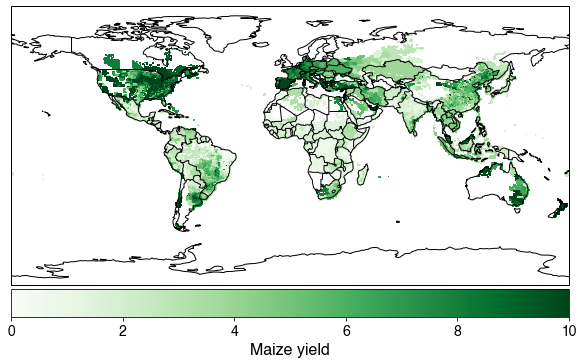

In [481]:
cRange=[0, 10]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak, np.clip(maizeYield.Data.values[:,:,-1], cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('Maize yield')
ax.coastlines()

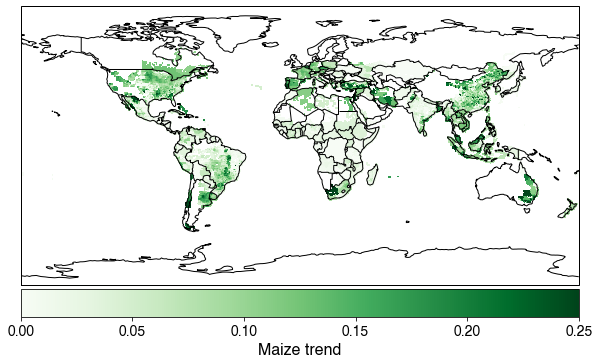

In [482]:
cRange=[0, .25]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('Maize trend')
ax.coastlines()

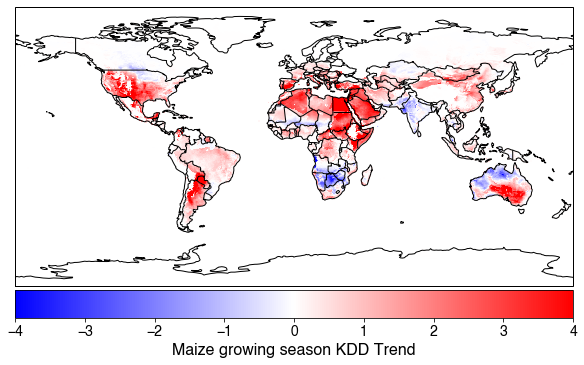

In [483]:
cRange=[-4, 4]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(tempLon, tempLat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(tempLon, tempLat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

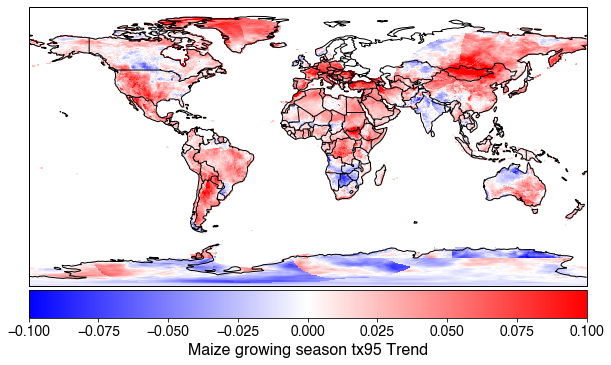

In [484]:
cRange=[-.1, .1]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(tempLon, tempLat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(tempLon, tempLat, np.clip(tx95Trends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .025))
cbar.set_label('%s growing season tx95 Trend'%crop)
ax.coastlines()

In [485]:
rebuild=True

oldDataStr = 'new'
if yieldDataOld:
    oldDataStr = 'old'

if os.path.isfile('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldDataStr)) and not rebuild:
    with open('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldDataStr), 'rb') as f:
        modelData = pickle.load(f)
        
        pointModelsKDD = modelData['pointModelsKdd']
        pointModelsTx95 = modelData['pointModelsTx95']
        
        print('loaded %s'%('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldDataStr)))
else:
    minCropYears = 20

    pointModelsKDD = {}
    pointModelsTx95 = {}

    for xlat in range(0, len(latDeepak)):

        if xlat % 10 == 0: print('%.0f %%'%(xlat/len(latDeepak)*100))

        pointModelsKDD[xlat] = {}
        pointModelsTx95[xlat] = {}

        for ylon in range(0, len(lonDeepak)):

            y = maizeYield.Data.values[xlat, ylon, :]
            ptMaxDeepak = findConsec(y)

            lat1 = latDeepak[xlat]
            lat2 = latDeepak[xlat] + (latDeepak[1]-latDeepak[0])

            lon1 = lonDeepak[ylon]
            lon2 = lonDeepak[ylon] + (lonDeepak[1]-lonDeepak[0])

            if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYears:

                indLat = [np.where(abs(tempLat-lat1) == np.nanmin(abs(tempLat-lat1)))[0][0],
                           np.where(abs(tempLat-lat2) == np.nanmin(abs(tempLat-lat2)))[0][0]]
                indLon = [np.where(abs(tempLon-lon1) == np.nanmin(abs(tempLon-lon1)))[0][0],
                           np.where(abs(tempLon-lon2) == np.nanmin(abs(tempLon-lon2)))[0][0]]

                indLatRange = np.arange(indLat[0], indLat[1]+1)
                indLonRange = np.arange(indLon[0], indLon[1]+1)

                k = np.nanmean(kdd[indLatRange, :, :], axis=0)
                k = np.nanmean(k[indLonRange, :], axis=0)

                g = np.nanmean(gdd[indLatRange, :, :], axis=0)
                g = np.nanmean(g[indLonRange, :], axis=0)
                
                curTx95 = np.nanmean(tx95[indLatRange, :, :], axis=0)
                curTx95 = np.nanmean(curTx95[indLonRange, :], axis=0)

                indLatPr = [np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0],
                           np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0]]
                indLonPr = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                           np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]

                indLatPrRange = np.arange(indLatPr[0], indLatPr[1]+1)
                indLonPrRange = np.arange(indLonPr[0], indLonPr[1]+1)

                p = np.nanmean(seasonalPrecip[indLatPrRange, :, :], axis=0)
                p = np.nanmean(p[indLonPrRange, :], axis=0)
                
                g = g[ptMaxDeepak[0]:ptMaxDeepak[1]]
                k = k[ptMaxDeepak[0]:ptMaxDeepak[1]]
                p = p[ptMaxDeepak[0]:ptMaxDeepak[1]]
                y = y[ptMaxDeepak[0]:ptMaxDeepak[1]]
                curTx95 = curTx95[ptMaxDeepak[0]:ptMaxDeepak[1]]
                
                if len(np.where(np.isnan(k))[0]) == 0 and \
                    len(np.where(np.isnan(g))[0]) == 0 and \
                    len(np.where(np.isnan(p))[0]) == 0 and \
                    len(np.where(np.isnan(y))[0]) == 0 and \
                    len(np.where(np.isnan(curTx95))[0]) == 0:
                    
                    g = scipy.signal.detrend(g)
                    k = scipy.signal.detrend(k)
                    p = scipy.signal.detrend(p)
                    y = scipy.signal.detrend(y)
                    curTx95 = scipy.signal.detrend(curTx95)
                else:
                    continue

                if len(np.where((np.isnan(k)) | (k == 0))[0]) == 0 and \
                    len(np.where((np.isnan(g)) | (g == 0))[0]) == 0 and \
                    len(np.where((np.isnan(p)) | (p == 0))[0]) == 0:

                    data = {'GDD':g, \
                            'KDD':k, \
                            'Pr':p, \
                            'Yield':y}

                    df = pd.DataFrame(data, \
                                      columns=['GDD', 'KDD', 'Pr', \
                                               'Yield'])

                    mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                    pointModelsKDD[xlat][ylon] = mdl
                
                
                if len(np.where((np.isnan(curTx95)) | (curTx95 == 0))[0]) == 0 and \
                    len(np.where((np.isnan(p)) | (p == 0))[0]) == 0:

                    data = {'tx95':curTx95, \
                            'Pr':p, \
                            'Yield':y}

                    df = pd.DataFrame(data, \
                                      columns=['tx95', 'Pr', \
                                               'Yield'])

                    mdl = smf.ols(formula='Yield ~ tx95 + Pr', data=df).fit()
                    pointModelsTx95[xlat][ylon] = mdl

    with open('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldDataStr), 'wb') as f:
        modelData = {'pointModelsKDD':pointModelsKDD}
        pickle.dump(modelData, f)

0 %
3 %
6 %
8 %
11 %
14 %
17 %
19 %
22 %
25 %
28 %
31 %
33 %
36 %
39 %
42 %
44 %
47 %
50 %
53 %
56 %
58 %
61 %
64 %
67 %
69 %
72 %
75 %
78 %
81 %
83 %
86 %
89 %
92 %
94 %
97 %


In [486]:
yieldKddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldGddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldPrCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlKDDR2 = np.full([len(latDeepak), len(lonDeepak)], np.nan)

yield_tx95_tx95Coef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yield_tx95_prCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yield_tx95_r2 = np.full([len(latDeepak), len(lonDeepak)], np.nan)

for xlat in range(yieldKddCoef.shape[0]):
    
    if xlat not in pointModelsKDD.keys():
        continue
    
    for ylon in range(yieldKddCoef.shape[1]):
        
        if ylon not in pointModelsKDD[xlat].keys():
            continue
        
        yieldKddCoef[xlat, ylon] = pointModelsKDD[xlat][ylon].params['KDD']
        yieldGddCoef[xlat, ylon] = pointModelsKDD[xlat][ylon].params['GDD']
        yieldPrCoef[xlat, ylon] = pointModelsKDD[xlat][ylon].params['Pr']
        yieldMdlKDDR2[xlat, ylon] = pointModelsKDD[xlat][ylon].rsquared
        
        yield_tx95_tx95Coef[xlat, ylon] = pointModelsTx95[xlat][ylon].params['tx95']
        yield_tx95_prCoef[xlat, ylon] = pointModelsTx95[xlat][ylon].params['Pr']
        yield_tx95_r2[xlat, ylon] = pointModelsTx95[xlat][ylon].rsquared

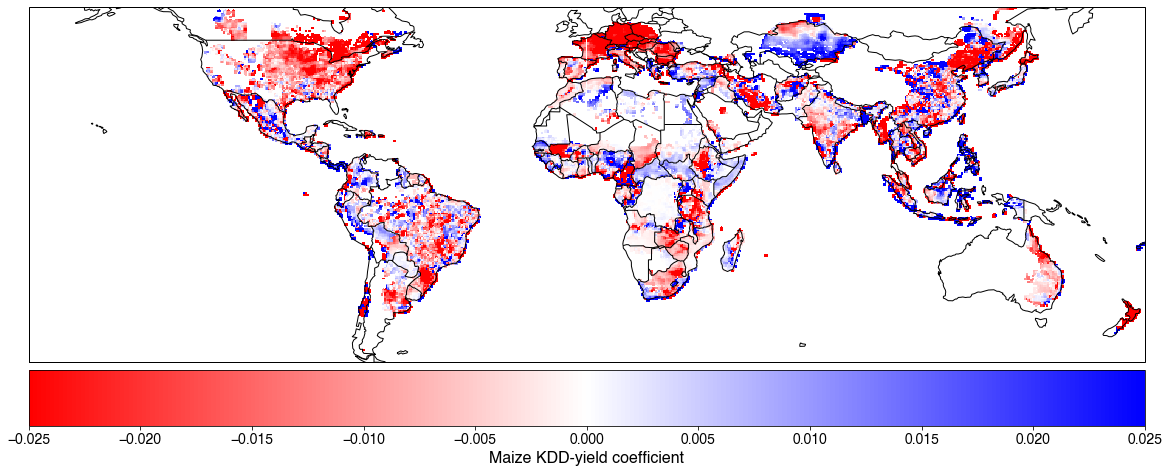

In [487]:
cRange=[-.025, .025]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(yieldKddCoef[60:-70, :], cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .005))
cbar.set_label('%s KDD-yield coefficient'%crop)
ax.coastlines()

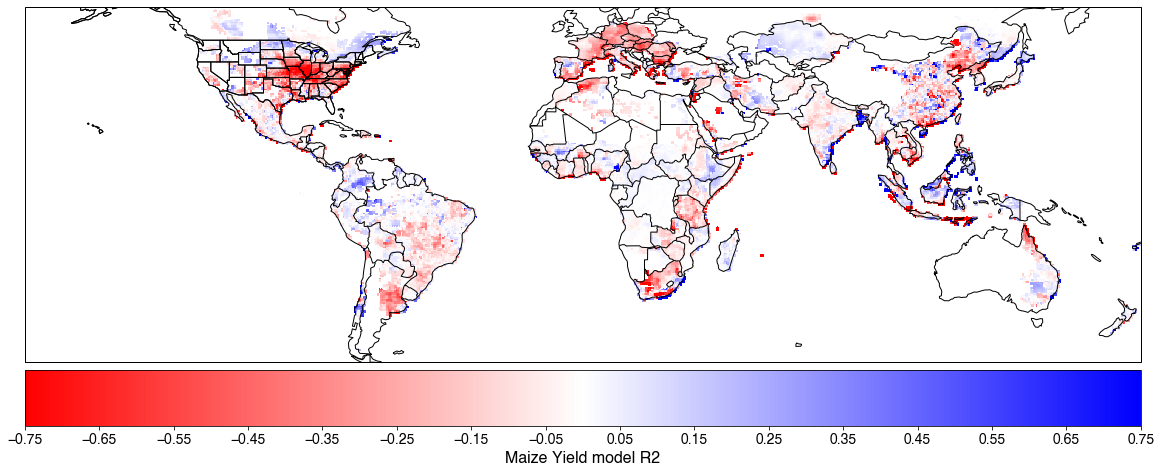

In [488]:
cRange=[-.75, .75]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldMdlR2, cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(yield_tx95_tx95Coef[60:-70,:], cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s Yield model R2'%crop)
ax.coastlines()

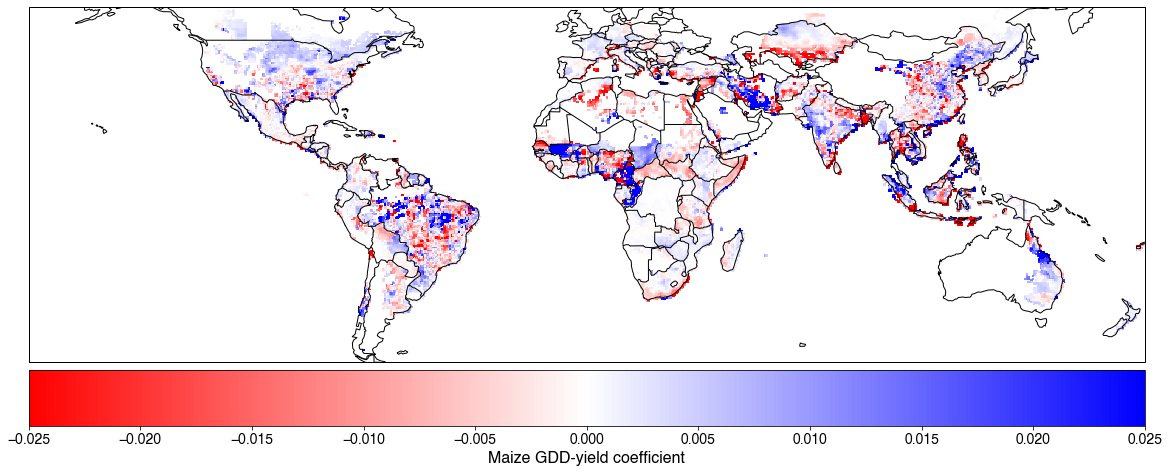

In [489]:
cRange=[-.025, .025]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(yieldGddCoef[60:-70, :], cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .005))
cbar.set_label('%s GDD-yield coefficient'%crop)
ax.coastlines()

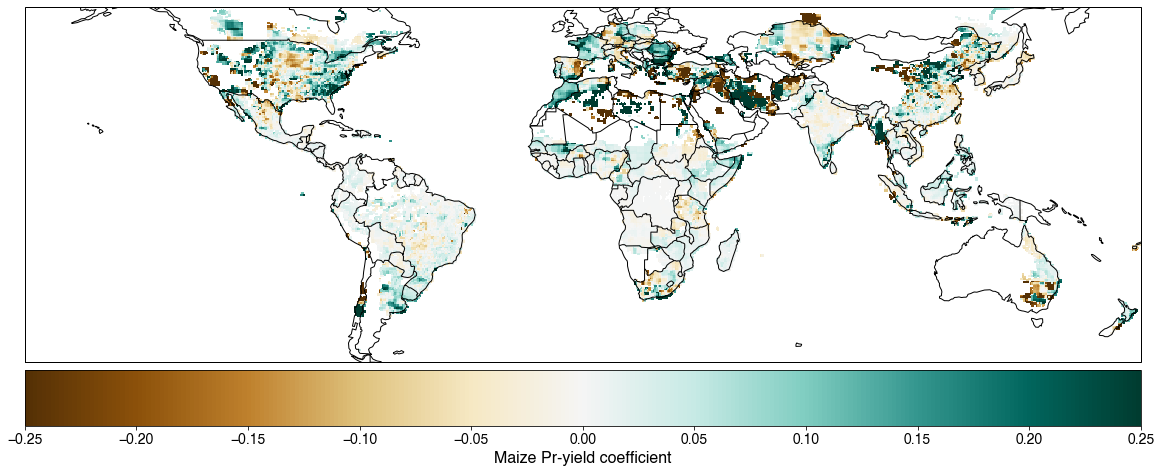

In [490]:
cRange=[-.25, .25]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(yieldPrCoef[60:-70, :], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('%s Pr-yield coefficient'%crop)
ax.coastlines()

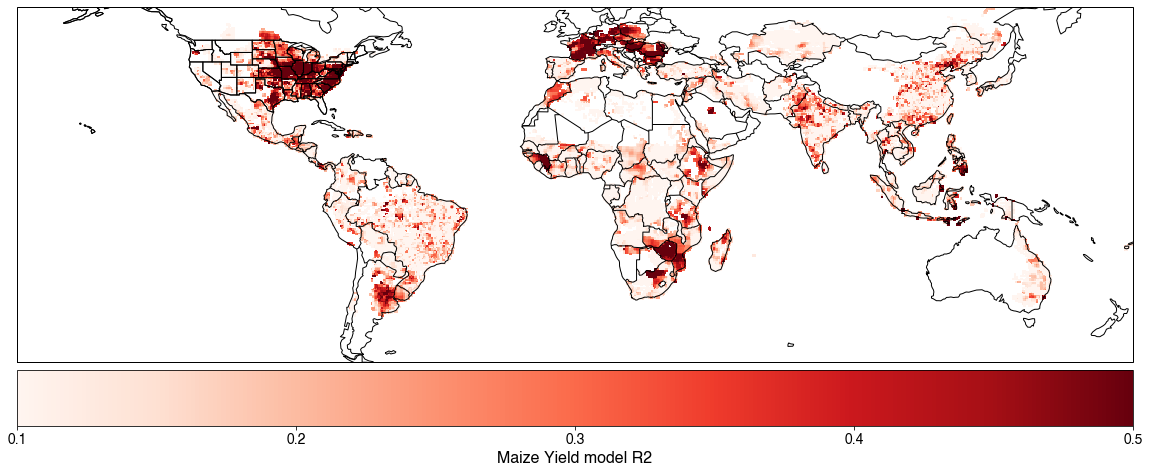

In [491]:
cRange=[.1, .5]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldMdlR2, cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(yieldMdlR2[60:-70,:], cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s Yield model R2'%crop)
ax.coastlines()

In [ ]:

reproject = True

if os.path.isfile('%s/global-yield-projections-%s-%s-%s'%(dataDirDiscovery, crop, wxData, oldDataStr)) and not reproject:
    
    with open('%s/global-yield-projections-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
        globalYieldProj = pickle.load(f)
        yieldProj = globalYieldProj['yieldProj']
        globalKddChg = globalYieldProj['globalKddChg']
        globalGddChg = globalYieldProj['globalGddChg']
        globalPrChg = globalYieldProj['globalPrChg']
    
    print('loaded %s'%('%s/global-yield-projections-%s-%s-%s'%(dataDirDiscovery, crop, wxData, oldDataStr)))
else:
    # project climate-related yield change with point models

    yieldProj = np.full([len(latDeepak), len(lonDeepak)], np.nan)
    globalKddChg = np.full([len(latDeepak), len(lonDeepak)], np.nan)
    globalGddChg = np.full([len(latDeepak), len(lonDeepak)], np.nan)
    globalPrChg = np.full([len(latDeepak), len(lonDeepak)], np.nan)

    periodLen = range(5,15)


    for xlat in range(len(latDeepak)):

        if xlat % 10 == 0:
            print('%.0f %%'%(xlat/len(latDeepak)*100))

        if xlat not in pointModels.keys():
            continue

        for ylon in range(len(lonDeepak)):

            if ylon not in pointModels[xlat].keys():
                continue

            lat1 = latDeepak[xlat]
            lat2 = latDeepak[xlat] + (latDeepak[1]-latDeepak[0])

            lon1 = lonDeepak[ylon]
            lon2 = lonDeepak[ylon] + (lonDeepak[1]-lonDeepak[0])

            indLat = [np.where(abs(tempLat-lat1) == np.nanmin(abs(tempLat-lat1)))[0][0],
                       np.where(abs(tempLat-lat2) == np.nanmin(abs(tempLat-lat2)))[0][0]]
            indLon = [np.where(abs(tempLon-lon1) == np.nanmin(abs(tempLon-lon1)))[0][0],
                       np.where(abs(tempLon-lon2) == np.nanmin(abs(tempLon-lon2)))[0][0]]

            indLatRange = np.arange(indLat[0], indLat[1]+1)
            indLonRange = np.arange(indLon[0], indLon[1]+1)

            indLatPr = [np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0],
                       np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0]]
            indLonPr = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                       np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]

            indLatPrRange = np.arange(indLatPr[0], indLatPr[1]+1)
            indLonPrRange = np.arange(indLonPr[0], indLonPr[1]+1)

            curProj = []

            curKddStarts = []
            curKddEnds = []
            curGddStarts = []
            curGddEnds = []
            curPrStarts = []
            curPrEnds = []

            curKdd = np.nanmean(kdd[indLatRange, :, :], axis=0)
            curKdd = np.nanmean(curKdd[indLonRange, :], axis=0)
            
            curGdd = np.nanmean(gdd[indLatRange, :, :], axis=0)
            curGdd = np.nanmean(curGdd[indLonRange, :], axis=0)
            
            curPr = np.nanmean(seasonalPrecip[indLatPrRange, :, :], axis=0)
            curPr = np.nanmean(curPr[indLonPrRange, :], axis=0)
            
            X = sm.add_constant(range(len(curKdd)))
            mdl = sm.OLS(curKdd, X).fit()
            curKddInt = mdl.params[0]
            curKddTrend = mdl.params[1]
            
            X = sm.add_constant(range(len(curGdd)))
            mdl = sm.OLS(curGdd, X).fit()
            curGddInt = mdl.params[0]
            curGddTrend = mdl.params[1]
            
            X = sm.add_constant(range(len(curPr)))
            mdl = sm.OLS(curPr, X).fit()
            curPrInt = mdl.params[0]
            curPrTrend = mdl.params[1]
            
            dataStart = {'GDD':[curGddInt], \
                    'KDD':[curKddInt], \
                    'Pr':[curPrInt]}
            dataEnd = {'GDD':[(curGddInt+curGddTrend*(2020-1979))], \
                    'KDD':[(curKddInt+curKddTrend*(2020-1979))], \
                    'Pr':[(curPrInt+curPrTrend*(2020-1979))]}

            dfStart = pd.DataFrame(dataStart, columns=['GDD', 'KDD', 'Pr'])
            dfEnd = pd.DataFrame(dataEnd, columns=['GDD', 'KDD', 'Pr'])

            curProjStarts = pointModels[xlat][ylon].predict(dfStart)
            curProjEnds = pointModels[xlat][ylon].predict(dfEnd)

            chg = ((curProjEnds-curProjStarts)/np.nanmean(maizeYield.Data.values[xlat, ylon, :])).values*100
            if chg < -100 or chg > 100: chg = np.nan
                
            yieldProj[xlat, ylon] = chg
            globalKddChg[xlat, ylon] = dfEnd['KDD'].values-dfStart['KDD'].values
            globalGddChg[xlat, ylon] = dfEnd['GDD'].values-dfStart['GDD'].values
            globalPrChg[xlat, ylon] = dfEnd['Pr'].values-dfStart['Pr'].values

#             curProjChg.append(chg)
#             curKddChg.append(np.nanmean(curKddEnds[i1:i2])-np.nanmean(curKddStarts[i1:i2]))
#             curGddChg.append(np.nanmean(curGddEnds[i1:i2])-np.nanmean(curGddStarts[i1:i2]))
#             curPrChg.append(np.nanmean(curPrEnds[i1:i2])-np.nanmean(curPrStarts[i1:i2]))

#             tval, pval = scipy.stats.ttest_1samp(curProjChg, 0)
#             if pval <= 0.05:
#                 yieldProj[xlat, ylon] = np.nanmean(curProjChg)
#                 globalKddChg[xlat, ylon] = np.nanmean(curKddChg)
#                 globalGddChg[xlat, ylon] = np.nanmean(curGddChg)
#                 globalPrChg[xlat, ylon] = np.nanmean(curPrChg)
    sys.exit()
    with open('%s/global-yield-projections-trendMethod-%s-%s-%s'%(dataDirDiscovery, crop, wxData, oldDataStr), 'wb') as f:
        globalYieldProj = {'yieldProj':yieldProj, \
                           'globalKddChg':globalKddChg, \
                           'globalGddChg':globalGddChg, \
                           'globalPrChg':globalPrChg}
        pickle.dump(globalYieldProj, f)

0 %
3 %
6 %
8 %
11 %
14 %
17 %
19 %
22 %
25 %
28 %
31 %
33 %


In [503]:
yieldProjR2Filter = yieldProj.copy()
yieldProjR2Filter[yieldMdlR2<0.1]=np.nan

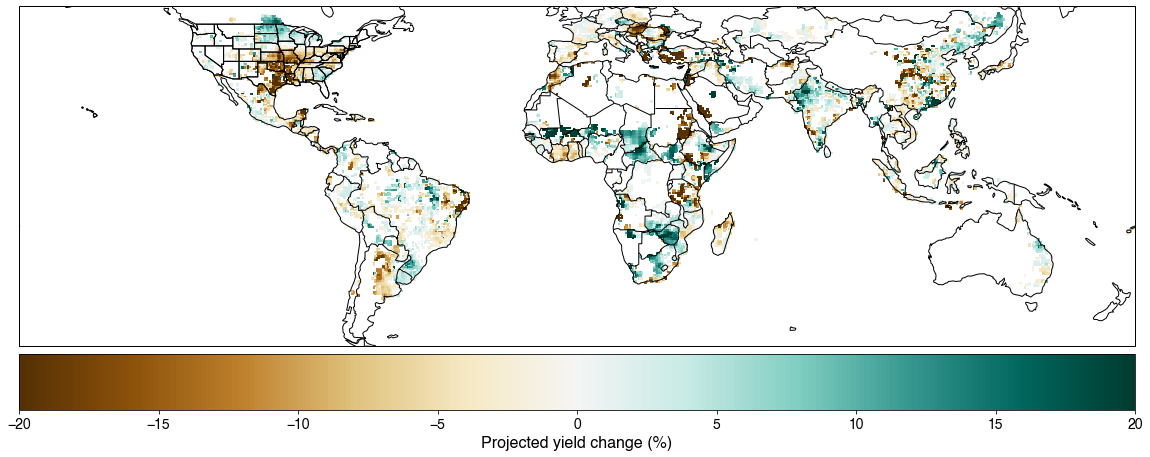

In [504]:
cRange=[-20, 20]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldProj, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[70:-70], np.clip(yieldProjR2Filter[70:-70,:], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 5))
cbar.set_label('Projected yield change (%)')
ax.coastlines()

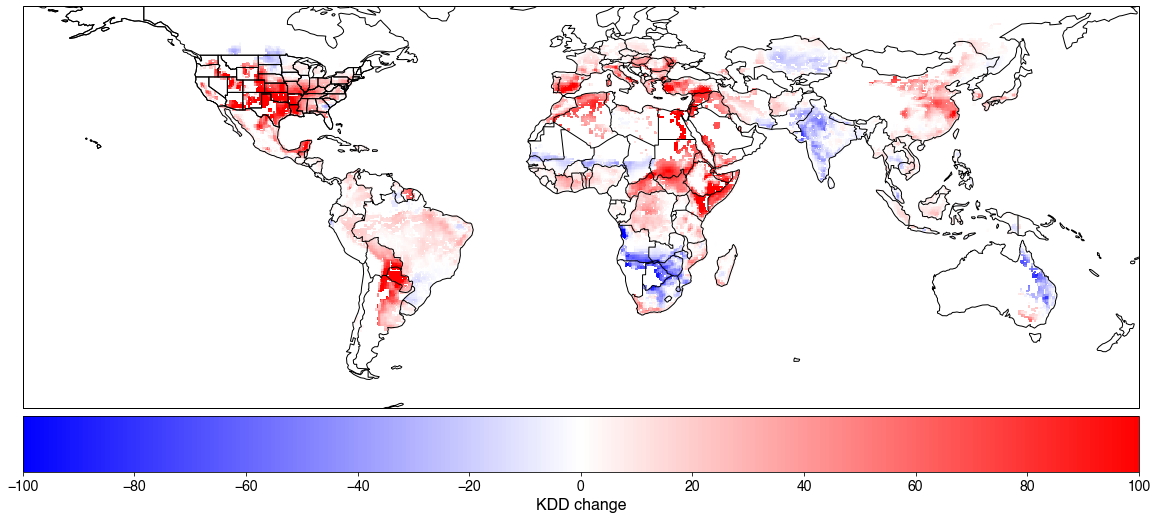

In [500]:
cRange=[-100, 100]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-50], np.clip(globalKddChg[50:-50,:], cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 20))
cbar.set_label('KDD change')
ax.coastlines()

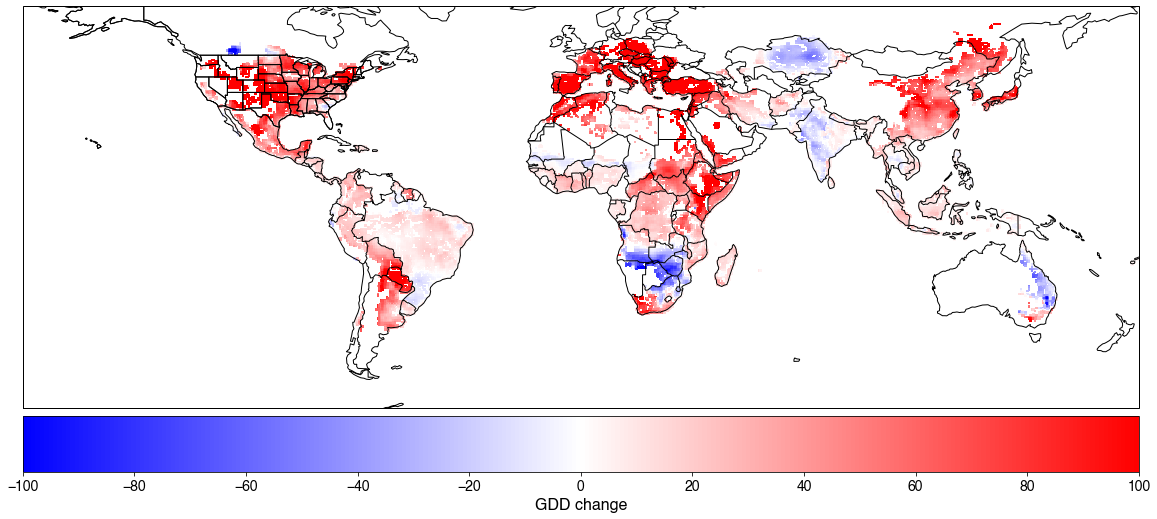

In [501]:
cRange=[-100, 100]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-50], np.clip(globalGddChg[50:-50,:], cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 20))
cbar.set_label('GDD change')
ax.coastlines()

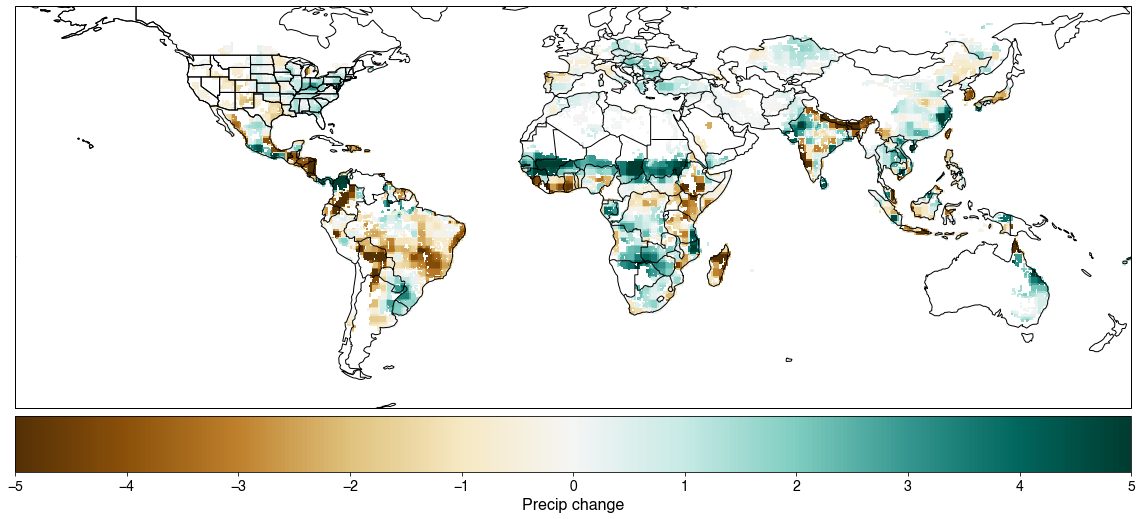

In [502]:
cRange=[-5, 5]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-50], np.clip(globalPrChg[50:-50,:], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('Precip change')
ax.coastlines()

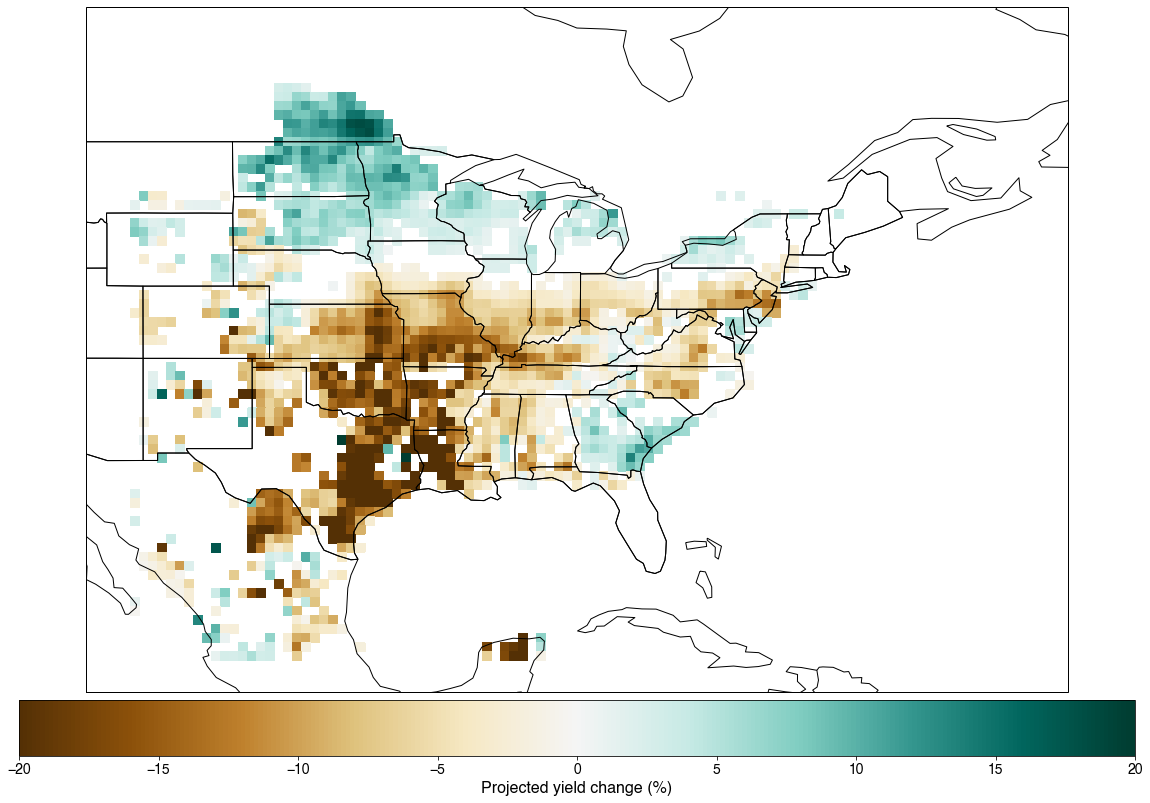

In [505]:
cRange=[-20, 20]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldProj, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak[500:600], latDeepak[70:140], np.clip(yieldProjR2Filter[70:140,500:600], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 5))
cbar.set_label('Projected yield change (%)')
ax.coastlines()